### Задание

- Кластеризовать датасет lfw_people двумя разными методами (иерархическая кластеризация и алгоритм $K$-means).
- Автоматически найти оптимальное число кластеров.

### Анализ
ML методами данный датасет качественно кластеризовать не получилось. В работе будет использоваться нейронная сеть для получения вектора из фотографии лица а затем кластеризоваться будут сами вектора.

### Имплементация

Отобразим часть датасета

Размер массива наблюдений X: (1456, 62, 47)
Размер массива меток классов y: (1456,)
Уникальных классов: 10


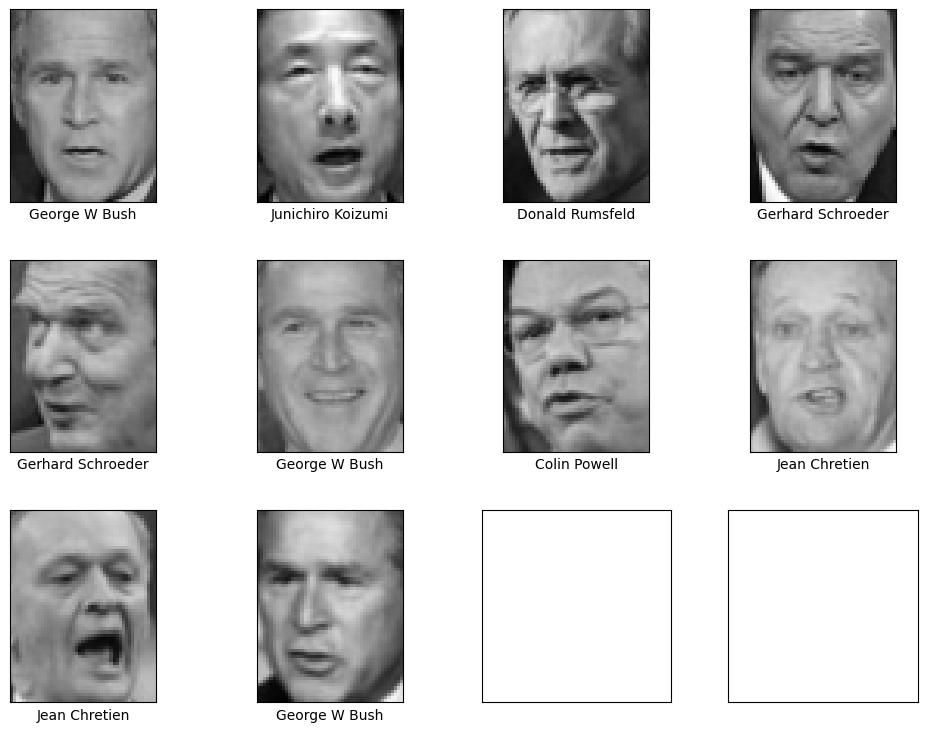

In [23]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

lfw_people = fetch_lfw_people(min_faces_per_person=53)
X = lfw_people.images
y = lfw_people.target

print(f"Размер массива наблюдений X: {X.shape}")
print(f"Размер массива меток классов y: {y.shape}")
print(f"Уникальных классов: {len(set(y))}")

fig, axes = plt.subplots(3, 4, figsize=(12, 9), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.3)
target_names = lfw_people.target_names

for i, ax in enumerate(axes.flat):
    ax.imshow(X[i], cmap='gray', vmin=0, vmax=1)
    ax.set_xlabel(target_names[y[i]])
    if i >= 9:
        break

plt.show()

Преобразуем фото в вектора и нормализуем их

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from deepface import DeepFace
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def extract_features(images):
    features = []
    for img in images:
        # Преобразуем изображение в RGB (DeepFace ожидает 3 канала)
        img_rgb = np.stack([img * 255] * 3, axis=-1)
        # Извлекаем признаки
        try:
            embedding = DeepFace.represent(img_rgb, model_name='VGG-Face', enforce_detection=False) #SFace
            features.append(embedding[0]['embedding'])  # Извлекаем embedding из результата
        except Exception as e:
            print(f"Ошибка при обработке изображения: {e}")
            features.append(np.zeros(128))  # Заполняем нулями в случае ошибки
    return np.array(features)

X_features = extract_features(X)

# Нормализация данных
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

Проведем кластеризацию методами AgglomerativeClustering и KMeans перебирая количество кластеров. Оценим результаты используя метрики silhouette_score и homogeneity_completeness_v_measure

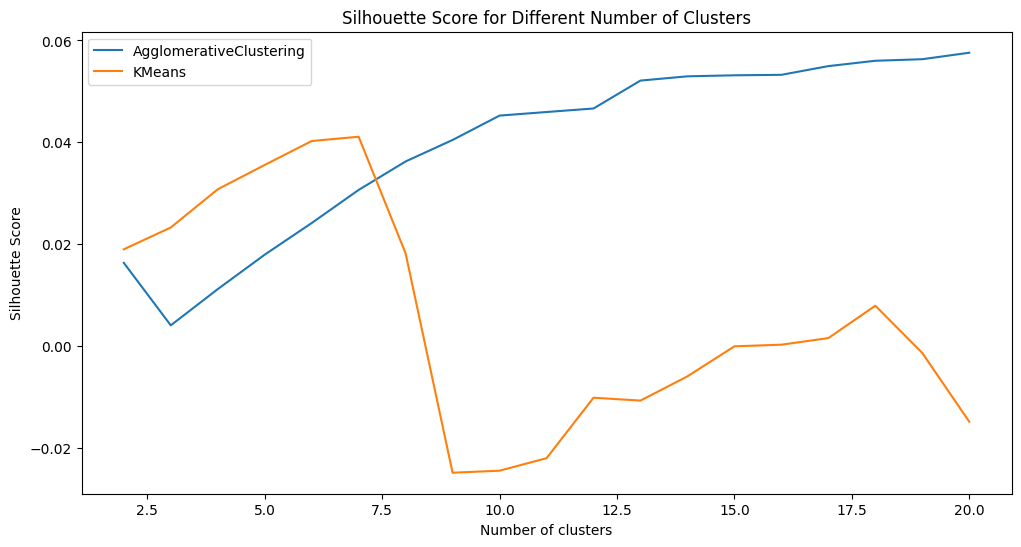

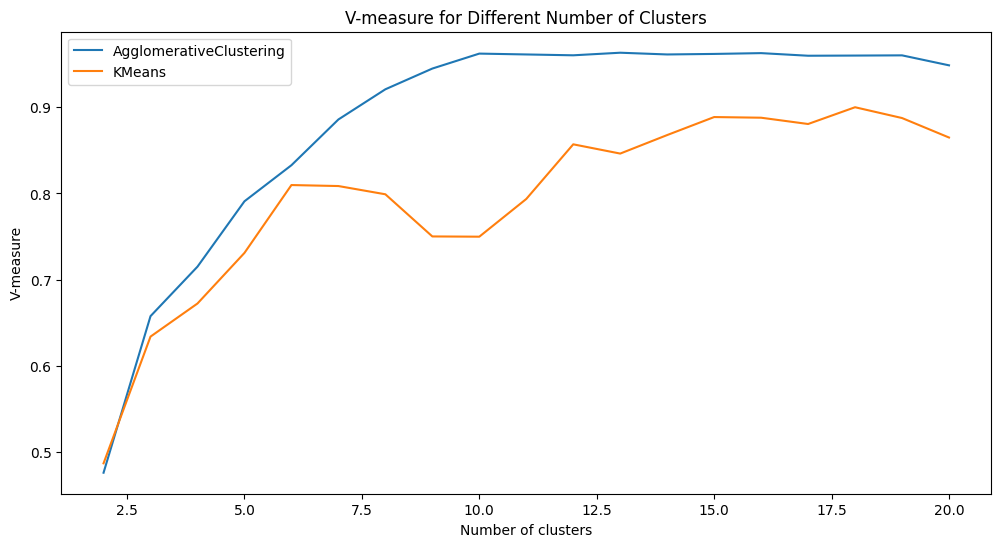

In [21]:
def evaluate_clustering(X, n_clusters):
    agg = AgglomerativeClustering(n_clusters=n_clusters) 
    agg_labels = agg.fit_predict(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_labels = kmeans.fit_predict(X)
    
    agg_silhouette = silhouette_score(X, agg_labels)
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    
    agg_v_measure = homogeneity_completeness_v_measure(y, agg_labels)
    kmeans_v_measure = homogeneity_completeness_v_measure(y, kmeans_labels)
    
    return agg_silhouette, kmeans_silhouette, agg_v_measure, kmeans_v_measure

def find_optimal_clusters(X, cluster_range):
    silhouette_scores_agg = []
    silhouette_scores_kmeans = []
    v_measures_agg = []
    v_measures_kmeans = []
    
    for n_clusters in cluster_range:
        agg_silhouette, kmeans_silhouette, agg_v_measure, kmeans_v_measure = evaluate_clustering(X, n_clusters)
        silhouette_scores_agg.append(agg_silhouette)
        silhouette_scores_kmeans.append(kmeans_silhouette)
        v_measures_agg.append(agg_v_measure)
        v_measures_kmeans.append(kmeans_v_measure)
    
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, silhouette_scores_agg, label='AgglomerativeClustering')
    plt.plot(cluster_range, silhouette_scores_kmeans, label='KMeans')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different Number of Clusters')
    plt.legend()
    plt.show()
    
    # График v_measure
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, [v[2] for v in v_measures_agg], label='AgglomerativeClustering')
    plt.plot(cluster_range, [v[2] for v in v_measures_kmeans], label='KMeans')
    plt.xlabel('Number of clusters')
    plt.ylabel('V-measure')
    plt.title('V-measure for Different Number of Clusters')
    plt.legend()
    plt.show()

cluster_range = range(2, 21)
find_optimal_clusters(X_features_scaled, cluster_range)

Как видно из графиков, однозначное количество кластеров получить не удалось. Наиболее близкое к реальности число получилось с использованием V-measure + AgglomerativeClustering. Попробуем улучшить метод используя TruncatedSVD для уменьшения размерности.

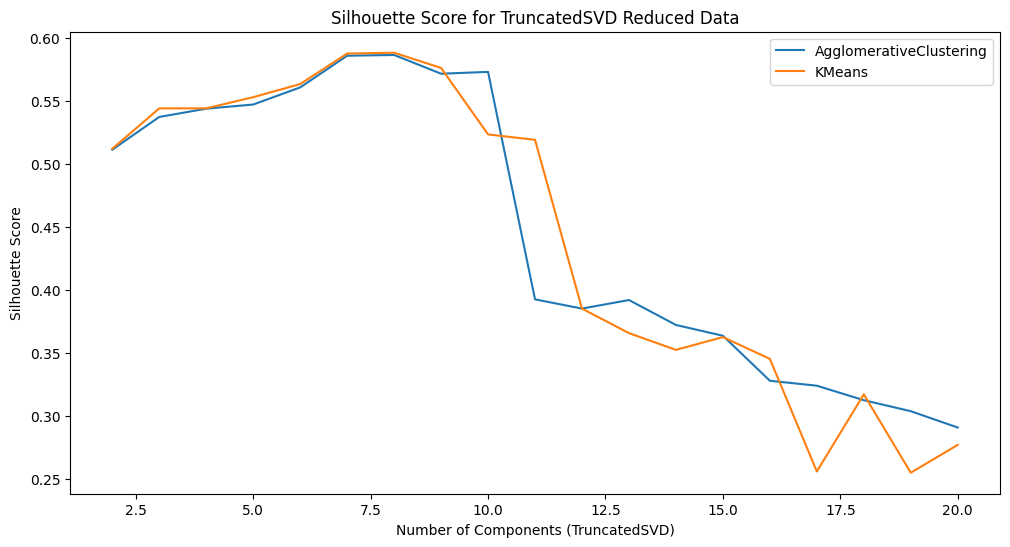

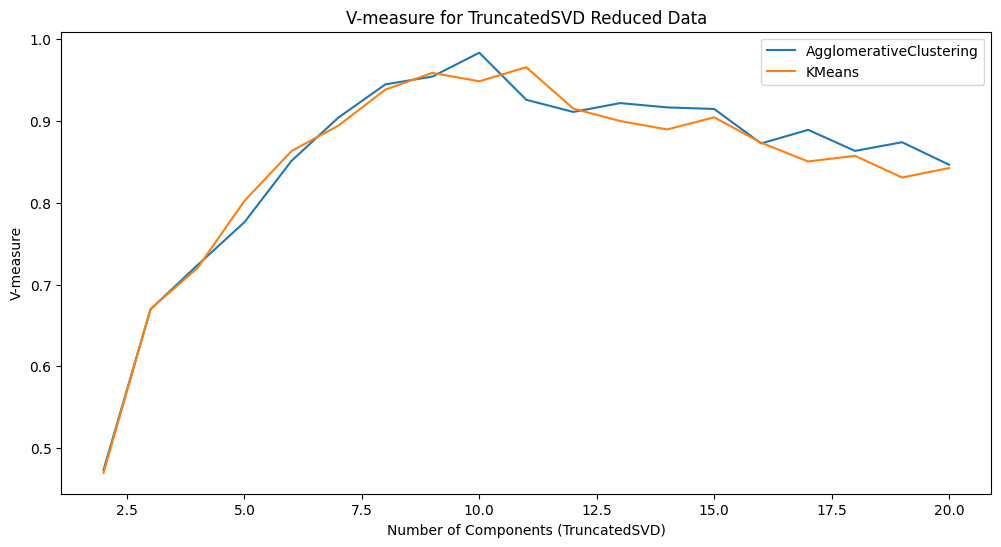

In [6]:
def evaluate_svd_clustering(X, n_components_range):
    silhouette_scores_agg = []
    silhouette_scores_kmeans = []
    v_measures_agg = []
    v_measures_kmeans = []
    
    for n_components in n_components_range:
        svd = TruncatedSVD(n_components=n_components, random_state=0)
        X_reduced = svd.fit_transform(X)
        
        agg_silhouette, kmeans_silhouette, agg_v_measure, kmeans_v_measure = evaluate_clustering(X_reduced, n_components)
        silhouette_scores_agg.append(agg_silhouette)
        silhouette_scores_kmeans.append(kmeans_silhouette)
        v_measures_agg.append(agg_v_measure)
        v_measures_kmeans.append(kmeans_v_measure)
    
    plt.figure(figsize=(12, 6))
    plt.plot(n_components_range, silhouette_scores_agg, label='AgglomerativeClustering')
    plt.plot(n_components_range, silhouette_scores_kmeans, label='KMeans')
    plt.xlabel('Number of Components (TruncatedSVD)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for TruncatedSVD Reduced Data')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(n_components_range, [v[2] for v in v_measures_agg], label='AgglomerativeClustering')
    plt.plot(n_components_range, [v[2] for v in v_measures_kmeans], label='KMeans')
    plt.xlabel('Number of Components (TruncatedSVD)')
    plt.ylabel('V-measure')
    plt.title('V-measure for TruncatedSVD Reduced Data')
    plt.legend()
    plt.show()

n_components_range = range(2, 21)
evaluate_svd_clustering(X_features_scaled, n_components_range)

По графикам видно, что оптимальное число кластеров по V-measure + AgglomerativeClustering соответствует датасету.  

Визуализируем облако точек и кластеризуем его.

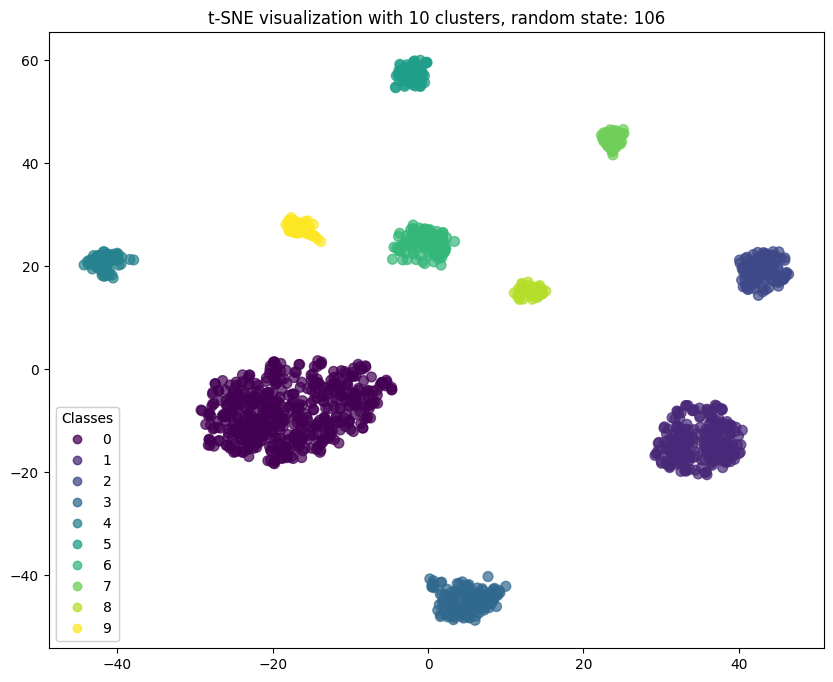

In [19]:
def visualize_tsne(X, n_clusters, random_state=0):
    svd = TruncatedSVD(n_components=n_clusters, random_state=random_state)
    X_reduced = svd.fit_transform(X)
    
    tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, n_iter=2000, random_state=random_state)
    X_tsne = tsne.fit_transform(X_reduced)
    
    kmeans = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    kmeans_labels = kmeans.fit_predict(X_tsne)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.title(f't-SNE visualization with {n_clusters} clusters, random state: {random_state}')
    plt.show()


visualize_tsne(X_features_scaled, 10, 106)

### Выводы
- Удалось точно определить количество кластеров, используя V-measure в сочетании с AgglomerativeClustering и уменьшением размерности через TruncatedSVD.
- Удалось визуализировать результаты кластеризации. Визуально наблюдается четкое разделение на 10 классов.